In [1]:
# Import Library
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import (AdamW, get_linear_schedule_with_warmup,AutoModelForTokenClassification, AutoTokenizer,DistilBertTokenizer, DistilBertForTokenClassification,Trainer, TrainingArguments)
from torch.nn.utils.rnn import pad_sequence


# Data

In [2]:
# Load datasets
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/train.csv")
dev_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/dev.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/test.csv")

# Dataset sizes
print("Train size:", train_data.shape)
print("Dev size:", dev_data.shape)
print("Test size:", test_data.shape)

# Quick preview
print("Train preview:\n", train_data.head())
print("Dev preview:\n", dev_data.head())
print("Test preview:\n", test_data.head())


Train size: (28931, 3)
Dev size: (3460, 3)
Test size: (4143, 3)
Train preview:
       word tag  abstract_id
0       In   O            0
1     this   O            0
2  article   O            0
3       we   O            0
4  discuss   O            0
Dev preview:
             word tag  abstract_id
0           This   O            0
1        article   O            0
2       presents   O            0
3             an   O            0
4  investigation   O            0
Test preview:
           word tag  abstract_id
0      Systems   O            0
1        based   O            0
2           on   O            0
3  synchronous   B            0
4     grammars   I            0


Tag Distribution Across Splits:
 tag         B       I        O    b
split                              
dev     408.0   405.0   2646.0  1.0
test    451.0   488.0   3204.0  0.0
train  3440.0  3562.0  21929.0  0.0


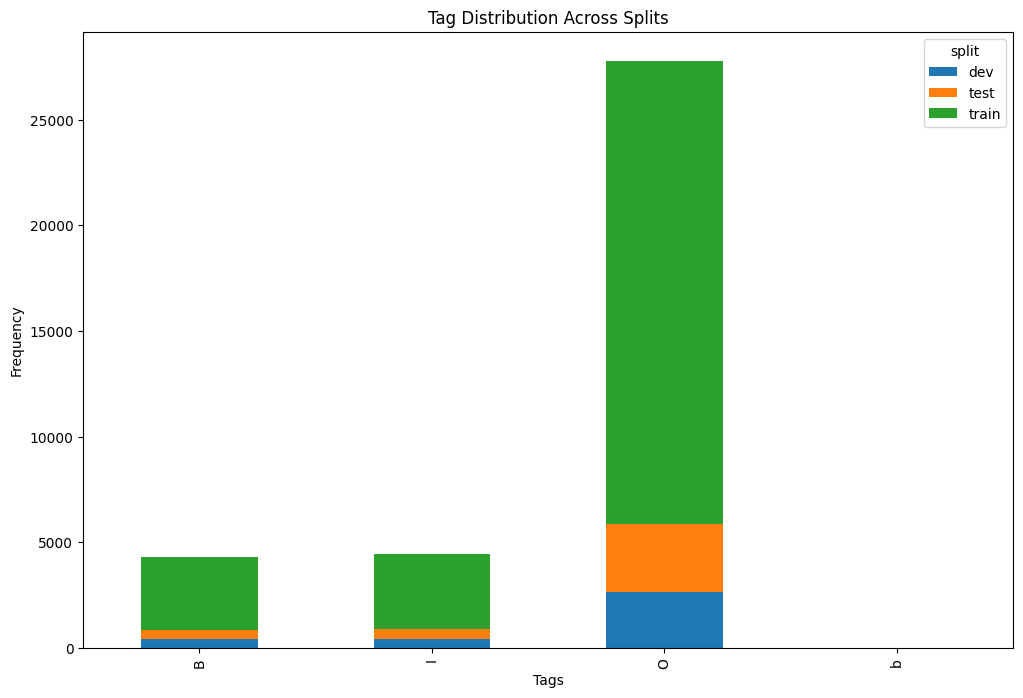

In [3]:
# Combine for global analysis
all_data = pd.concat([train_data.assign(split="train"),
                      dev_data.assign(split="dev"),
                      test_data.assign(split="test")])
# Tag distribution per split
tag_distribution = all_data.groupby('split')['tag'].value_counts().unstack().fillna(0)
print("Tag Distribution Across Splits:\n", tag_distribution)

# Visualize tag distributions
tag_distribution.T.plot(kind="bar", figsize=(12, 8), stacked=True)
plt.title("Tag Distribution Across Splits")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.show()


# Load Tokenizer

In [4]:
# Load tokenizer
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Map tags to indices
tag2id = {"O": 0, "B": 1, "I": 2}  # No need for 'b' anymore as we normalize the tags
id2tag = {v: k for k, v in tag2id.items()}

# Function to preprocess tags and convert 'b' to 'B'
def preprocess_tags(df):
    df['tag'] = df['tag'].apply(lambda x: 'B' if x == 'b' else x)
    return df

# Function to tokenize and align labels
def tokenize_and_align_labels(df):
    tokenized_data = {"input_ids": [], "attention_mask": [], "labels": []}

    # Group by abstract_id to process abstracts as units
    grouped = df.groupby("abstract_id")

    for abstract_id, group in grouped:
        words = group["word"].tolist()
        tags = group["tag"].tolist()

        # Tokenize words
        tokenized = tokenizer(words, truncation=True, is_split_into_words=True)

        # Align labels
        labels = []
        word_ids = tokenized.word_ids()
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)  # Special tokens
            else:
                tag = tags[word_idx]
                labels.append(tag2id.get(tag, -100))  # Default to -100 for unexpected tags

        tokenized_data["input_ids"].append(tokenized["input_ids"])
        tokenized_data["attention_mask"].append(tokenized["attention_mask"])
        tokenized_data["labels"].append(labels)

    return tokenized_data

# Preprocess the tags before tokenization
train_data = preprocess_tags(train_data)
dev_data = preprocess_tags(dev_data)
test_data = preprocess_tags(test_data)

# Process datasets
try:
    train_tokenized = tokenize_and_align_labels(train_data)
    dev_tokenized = tokenize_and_align_labels(dev_data)
    test_tokenized = tokenize_and_align_labels(test_data)
    print("Tokenization completed successfully!")
except Exception as e:
    print("An error occurred during tokenization:", str(e))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenization completed successfully!


In [5]:
# Create a custom Dataset class to handle tokenized data
class NERDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_masks = tokenized_data['attention_mask']
        self.labels = tokenized_data['labels']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Convert the tokenized data into Dataset objects
train_dataset = NERDataset(train_tokenized)
dev_dataset = NERDataset(dev_tokenized)
test_dataset = NERDataset(test_tokenized)


# Load Pretrained Model

In [6]:
# Load the pre-trained model
# Set num_labels to 9 to match the pre-trained model's output classes
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9, ignore_mismatched_sizes=True)

# Set the model to train mode
model.train()

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [7]:
# Create a custom collate function to pad sequences
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad sequences
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100) # Pad labels with -100

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

# Create DataLoader for training and validation sets using the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

Training with learning rate 5e-05 for 10 epochs...


Training Epoch 10/1000: 100%|██████████| 18/18 [06:11<00:00, 20.65s/it]


Epoch 10 - Average Training Loss: 0.7593
Epoch 10 - Average Validation Loss: 0.4485
Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoints/model_checkpoint.pth
Training with learning rate 5e-05 for 50 epochs...


Training Epoch 50/1000: 100%|██████████| 18/18 [05:55<00:00, 19.73s/it]


Epoch 50 - Average Training Loss: 0.3684
Epoch 50 - Average Validation Loss: 0.4168
Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoints/model_checkpoint.pth
Training with learning rate 5e-05 for 100 epochs...


Training Epoch 100/1000: 100%|██████████| 18/18 [06:03<00:00, 20.19s/it]


Epoch 100 - Average Training Loss: 0.3129
Epoch 100 - Average Validation Loss: 0.3970
Checkpoint saved to /content/drive/MyDrive/Colab Notebooks/checkpoints/model_checkpoint.pth
Training with learning rate 5e-05 for 1000 epochs...


Training Epoch 1000/1000: 100%|██████████| 18/18 [06:00<00:00, 20.05s/it]


Epoch 1000 - Average Training Loss: 0.2616
Epoch 1000 - Average Validation Loss: 0.4101


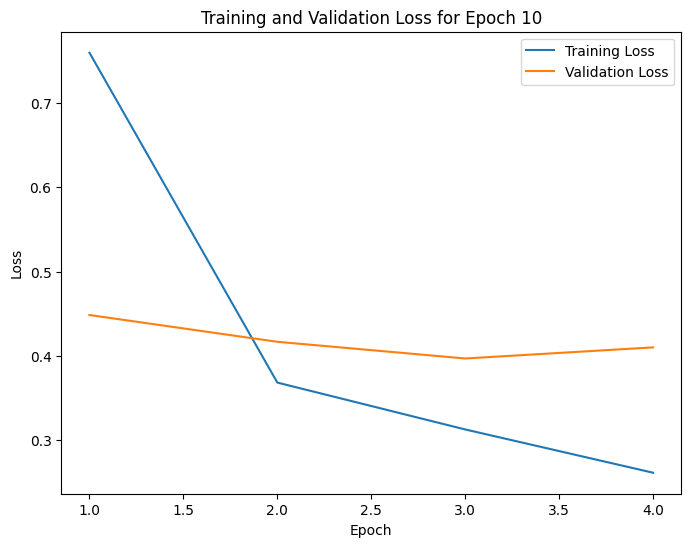

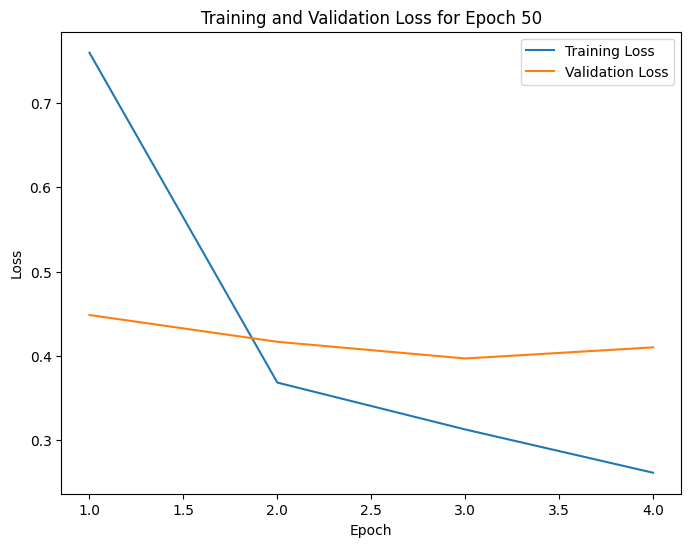

Best model found at epoch 100 with learning rate 5e-05 and validation loss 0.3970


In [8]:
import os
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

# Define checkpoint directory and filename
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/checkpoints/"
checkpoint_filename = "model_checkpoint.pth"

# Create the checkpoints directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Save model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

# Initialize lists to track the training and validation losses
train_losses = []
val_losses = []

# Modify the training loop to keep track of the best model
best_val_loss = float('inf')
best_epoch = 0
best_lr = 0

# Experimenting with different learning rates and epochs
learning_rates = [0.00005]  # Example learning rates
epochs_list = [10,50,100,1000]  # Example epoch combinations

# Loop through different learning rates and epochs
for lr in learning_rates:
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs_list[-1])

    for epoch in epochs_list:
        print(f"Training with learning rate {lr} for {epoch} epochs...")
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch}/{epochs_list[-1]}"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Epoch {epoch} - Average Training Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in dev_dataloader:
                input_ids = batch['input_ids'].to(model.device)
                attention_mask = batch['attention_mask'].to(model.device)
                labels = batch['labels'].to(model.device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(dev_dataloader)
        print(f"Epoch {epoch} - Average Validation Loss: {avg_val_loss:.4f}")

        # Track training and validation losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_lr = lr
            save_checkpoint(model, optimizer, epoch, avg_val_loss, checkpoint_dir + checkpoint_filename)

print(f"Best model found at epoch {best_epoch} with learning rate {best_lr} and validation loss {best_val_loss:.4f}")


# Evaluate the Model

In [19]:
def evaluate(model, dev_dataloader, tag2id): # Add tag2id as an argument
    model.eval()
    all_preds = []
    all_labels = []
    correct_predictions = 0  # To keep track of correct predictions
    total_predictions = 0  # To keep track of total valid predictions
    with torch.no_grad():
        for batch in dev_dataloader:
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            # Filter out predictions and labels for padding tokens (-100)
            active_labels = labels.view(-1).cpu().numpy()
            active_preds = preds.view(-1).cpu().numpy()

            valid_indices = active_labels != -100
            active_labels = active_labels[valid_indices]
            active_preds = active_preds[valid_indices]

            all_preds.extend(active_preds)
            all_labels.extend(active_labels)

            # Count correct predictions
            correct_predictions += np.sum(active_preds == active_labels)
            total_predictions += len(active_labels)

    # Generate classification report, limiting labels to those in tag2id
    report = classification_report(all_labels, all_preds,
                                   target_names=list(tag2id.keys()),
                                   labels=list(tag2id.values()), # Specify labels present in tag2id
                                   zero_division=0)  # Handle zero division errors

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    print("Accuracy: {:.4f}".format(accuracy))
    print(report)
# Evaluate on the validation data
print("Evaluating on validation data:")
evaluate(model, dev_dataloader, tag2id)

# Evaluate on the test data
print("Evaluating on test data:")
evaluate(model, test_dataloader, tag2id)


Evaluating on validation data:
Accuracy: 0.8561
              precision    recall  f1-score   support

           O       0.92      0.91      0.92      2816
           B       0.74      0.70      0.72       726
           I       0.68      0.77      0.72       538

   micro avg       0.86      0.86      0.86      4080
   macro avg       0.78      0.80      0.79      4080
weighted avg       0.86      0.86      0.86      4080

Evaluating on test data:
Accuracy: 0.8765
              precision    recall  f1-score   support

           O       0.91      0.93      0.92      3383
           B       0.77      0.75      0.76       783
           I       0.79      0.73      0.76       644

   micro avg       0.88      0.88      0.88      4810
   macro avg       0.83      0.80      0.81      4810
weighted avg       0.87      0.88      0.88      4810



In [11]:
# Save the model
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer")


('/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP_Models/fine_tuned_ner_tokenizer/tokenizer.json')

# Test model with custom data

In [25]:

# Input text
text = (
    "This study focuses on fine-tuning the DistilBERT model for Natural Language "
    "Processing (NLP) tasks, specifically emotion classification in textual data. "
    "Using the 'dair-ai/emotion' dataset, the model was trained to categorize emotions "
    "into predefined classes such as sadness, happiness, and anger. The text data underwent "
    "preprocessing, including tokenization and encoding, leveraging the 'distilbert-base-uncased' "
    "tokenizer. Techniques like padding and truncation ensured compatibility with the model's input requirements."
)

# Tokenize the input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Predict token classes
with torch.no_grad():
    outputs = model(**inputs).logits

# Get the predictions for each token
predicted_class_ids = torch.argmax(outputs, dim=-1).squeeze().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().cpu().numpy())
predicted_classes = [classes[class_id] for class_id in predicted_class_ids]

# Print tokens with their predicted classes
for token, label in zip(tokens, predicted_classes):
    print(f"{token}: {label}")


[CLS]: O
This: O
study: O
focuses: O
on: O
fine: O
-: O
tuning: O
the: O
Di: B
##st: B
##il: B
##BE: B
##RT: B
model: I
for: O
Natural: B
Language: I
Process: I
##ing: I
(: O
NL: B
##P: B
): O
tasks: O
,: O
specifically: O
emotion: B
classification: I
in: O
text: B
##ual: B
data: I
.: O
Using: O
the: O
': O
da: B
##ir: B
-: I
a: I
##i: I
/: O
emotion: O
': O
data: O
##set: O
,: O
the: O
model: O
was: O
trained: O
to: O
cat: O
##ego: O
##riz: O
##e: O
emotions: O
into: O
pre: B
##de: B
##fine: O
##d: B
classes: O
such: O
as: O
sadness: O
,: O
happiness: O
,: O
and: O
anger: O
.: O
The: O
text: B
data: O
underwent: O
pre: O
##p: O
##ro: O
##cess: O
##ing: O
,: O
including: O
token: B
##ization: B
and: O
encoding: B
,: O
lever: O
##aging: O
the: O
': O
di: B
##st: B
##il: B
##bert: B
-: I
base: I
-: I
un: I
##case: I
##d: I
': O
token: O
##izer: I
.: O
Tech: O
##ni: O
##ques: O
like: O
pad: B
##ding: B
and: O
t: B
##run: B
##cation: B
ensured: O
compatibility: O
with: O
the: O
model: O
':